In [64]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# Calling the data from the S3 bucket:
bucket_name = 'cloudfinalassignment'
file_key = 'database_nasa.csv'

s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Storing the data in a dataframe:
df = pd.read_csv(response['Body'])

# Analysing the dataframe:
print(df.head())
print(df.dtypes)

   Neo Reference ID     Name  Absolute Magnitude  Est Dia in KM(min)  \
0           3703080  3703080                21.6            0.127220   
1           3723955  3723955                21.3            0.146068   
2           2446862  2446862                20.3            0.231502   
3           3092506  3092506                27.4            0.008801   
4           3514799  3514799                21.6            0.127220   

   Est Dia in KM(max)  Est Dia in M(min)  Est Dia in M(max)  \
0            0.284472         127.219879         284.472297   
1            0.326618         146.067964         326.617897   
2            0.517654         231.502122         517.654482   
3            0.019681           8.801465          19.680675   
4            0.284472         127.219879         284.472297   

   Est Dia in Miles(min)  Est Dia in Miles(max)  Est Dia in Feet(min)  ...  \
0               0.079051               0.176763            417.388066  ...   
1               0.090762        

                              Neo Reference ID      Name  Absolute Magnitude  \
Neo Reference ID                      1.000000  1.000000            0.547038   
Name                                  1.000000  1.000000            0.547038   
Absolute Magnitude                    0.547038  0.547038            1.000000   
Est Dia in KM(min)                   -0.547038 -0.547038           -1.000000   
Est Dia in KM(max)                   -0.547038 -0.547038           -1.000000   
Est Dia in M(min)                    -0.547038 -0.547038           -1.000000   
Est Dia in M(max)                    -0.547038 -0.547038           -1.000000   
Est Dia in Miles(min)                -0.547038 -0.547038           -1.000000   
Est Dia in Miles(max)                -0.547038 -0.547038           -1.000000   
Est Dia in Feet(min)                 -0.547038 -0.547038           -1.000000   
Est Dia in Feet(max)                 -0.547038 -0.547038           -1.000000   
Epoch Date Close Approach             0.

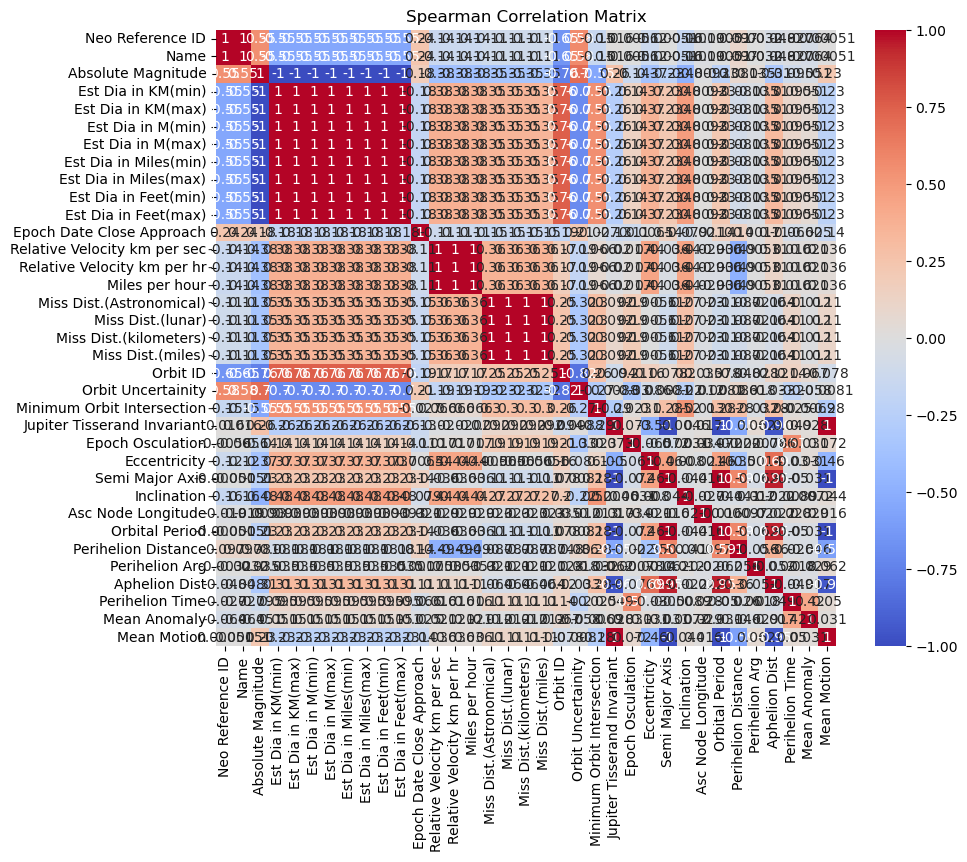

In [65]:
# Checking for correlation between the variables:
# We want to exclude high correlated variables
# Create a correlation matrix for further inspection:

import seaborn as sns
import matplotlib.pyplot as plt

# Excluding non-numeric columns:
numeric_columns = df.select_dtypes(include=['number'])

# Calculating the Spearman Correlation:
spearman_corr = numeric_columns.corr(method='spearman')

# Displaying the Spearman Correlation matrix:
print(spearman_corr)

# Visualizing the correlation matrix:
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [66]:
# We are dropping the following columns as the resamble the same information in different units, e.g. Est Dia in M(min), or are not relevant for the prediction, e.g. Orbit ID:
df = df.drop(columns = ["Est Dia in M(min)", "Est Dia in M(max)", "Est Dia in Miles(min)", "Est Dia in Miles(max)", "Est Dia in Feet(min)", "Est Dia in Feet(max)", "Relative Velocity km per hr", "Miss Dist.(lunar)","Miss Dist.(kilometers)", "Miss Dist.(miles)", "Orbit ID", "Close Approach Date", "Orbit Determination Date"])

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from io import StringIO


# Splitting the data into a training and test set:
train, test = train_test_split(df, test_size = 0.25, random_state = 42)

#Creating two branches for numerical and categorical features as a base for the transformer:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int', 'float']).columns.tolist()

# Creating the ColumnTransformer for categorical features directly:
inner_pipe_cat = Pipeline([
    ('mode', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False))
])

# Creating the ColumnTransformer for numerical features directly:
inner_pipe_num = Pipeline([
    ('mode', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Creating the ColumnTransformer directly without storing the transformers:
transformer = ColumnTransformer([
    ('inner_pipe_cat', inner_pipe_cat, categorical_features),
    ('inner_pipe_num', inner_pipe_num, numerical_features)
], remainder='passthrough')

# Fit-transforming the data with the transformer and storing it in a new DataFrame:
train = transformer.fit_transform(train)

# Storing the new train data in a dataframe:
train = pd.DataFrame(train)

# Fit-transforming the data with the transformer and storing it in a new DataFrame:
test = transformer.transform(test)

# Storing the new train data in a dataframe:
test = pd.DataFrame(test)

# Putting the last column as the first column in the train set
train = pd.concat([train.iloc[:, -1], train.iloc[:, :-1]], axis=1)

# Putting the last column as the first column in the test set
test = pd.concat([test.iloc[:, -1], test.iloc[:, :-1]], axis=1)

In [70]:
from io import StringIO

s3 = boto3.client('s3')

# Defining the file names of the train and test dataset:
train_file_name = 'database_nasa_train.csv'
test_file_name = 'database_nasa_test.csv'

# Converting the train dataframe to CSV format as a string:
csv_buffer_train = StringIO()
train.to_csv(csv_buffer_train, index=False)

# Upload CSV string to S3 with modified file name:
s3.put_object(Bucket='cloudfinalassignment', Key=train_file_name, Body=csv_buffer_train.getvalue())

# Print confirmation
print("Train CSV uploaded successfully to S3")

# Converting the test dataframe to CSV format as a string:
csv_buffer_test = StringIO()
test.to_csv(csv_buffer_test, index=False)

# Uploading the CSV string to S3 with modified file name:
s3.put_object(Bucket='cloudfinalassignment', Key=test_file_name, Body=csv_buffer_test.getvalue())

# Printing a confirmation for both sets:
print("Test CSV uploaded successfully to S3")

Train CSV uploaded successfully to S3
Test CSV uploaded successfully to S3
